<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_navier_stokes/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.galerkin import DGMNet
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.galerkin import DGMNet
import numbers
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import time
import logging
from pynverse import inversefunc
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.11.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sun Nov  6 21:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:07:00.0  On |                  N/A |
|  0%   43C    P8    29W / 350W |    489MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Navier-Stokes equation
$$
\begin{cases}
  \displaystyle
  \partial_t u_i(t,x) + \frac{\nu}{2} \Delta u_i(t,x) = \partial_{1_i} p(t,x) + \sum\limits_{j=0}^{d-1} u_j(t,x) \partial_{1_j} u_i(t,x), \quad i = 0,\ldots , d-1,
  \\
u_i(T,x) = \phi_i (x),
  \\
  \displaystyle
  \Delta u_{-1}(t, x) = -\sum\limits_{i,j=0}^{d-1} \partial_{1_j} u_i(t,x) \partial_{1_i} u_j(t,x),
   \\
\sum\limits_{i = 0}^{d - 1} \partial_{1_i} u_i(t, x) = 0, \quad (t,x) = (t,x_1, \ldots, x_d) \in [0,T] \times \mathbb{R}^d.
\end{cases}
$$

## 2-dimensional Taylor-Green vortex
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-2\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2) \in [0,2\pi]^2$.

In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
        [2, 0],  # for Laplacian
        [0, 2],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1, 0, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
        # Laplacian
        f += nu / 2 * (y[2 * dim + dim * dim + j])
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .25, nu = 2

In [5]:
T, nu = .25, 2

torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=10000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/notebooks/logs/20221106-212837-taylor_green_2d
Epoch 0 with loss 0.29005107283592224
Epoch 500 with loss 0.032900989055633545
Epoch 1000 with loss 0.019409626722335815
Epoch 1500 with loss 0.010213788598775864
Epoch 2000 with loss 0.0051663420163095
Epoch 2500 with loss 0.0017441695090383291
Epoch 3000 with loss 0.0018337336368858814
Epoch 3500 with loss 0.0007056955946609378
Epoch 4000 with loss 0.0005807155393995345
Epoch 4500 with loss 0.0003931762767024338
Epoch 5000 with loss 0.0019611106254160404
Epoch 5500 with loss 0.00027298106579110026
Epoch 6000 with loss 0.0002490086480975151
Epoch 6500 with loss 0.0003340146504342556
Epoch 7000 with loss 0.0006609833799302578
Epoch 7500 with loss 0.00016417265578638762
Epoch 8000 with loss 0.00017816066974774003
Epoch 8500 with loss 0.00013939390191808343
Epoch 9000 with loss 0.00013410605606622994
Epoch 9500 with loss 0.000277299084700644
Epoch 9999 with loss 0.00012883485760

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 6.77E-01 & 7.21E-01 & 7.68E-01 & 8.20E-01 & 8.77E-01 & 9.40E-01 & 1.01E+00 & 1.08E+00 & 1.17E+00 & 1.26E+00 & --- \\
$\hat{e}_1(t_k)$
& 2.27E-01 & 1.90E-01 & 1.55E-01 & 1.23E-01 & 9.36E-02 & 6.72E-02 & 4.45E-02 & 2.58E-02 & 1.19E-02 & 3.83E-03 & --- \\
$\hat{e}(t_k)$
& 7.10E-01 & 7.46E-01 & 7.88E-01 & 8.35E-01 & 8.88E-01 & 9.47E-01 & 1.01E+00 & 1.09E+00 & 1.17E+00 & 1.26E+00 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 9.12E-01 & 8.70E-01 & 8.34E-01 & 8.03E-01 & 7.77E-01 & 7.57E-01 & 7.40E-01 & 7.28E-01 & 7.19E-01 & 7.14E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 8.46E-01 & 8.17E-01 & 7.92E-01 & 7.70E-01 & 7.52E-01 & 7.38E-01 & 7.26E-01 & 7.18E-01 & 7.12E-01 & 7.08E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 3.05E+00 & 3.06E+00 & 3.06E+00 & 3.06E+00 & 3.07E+00 & 3.0

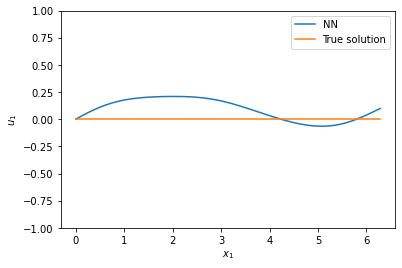

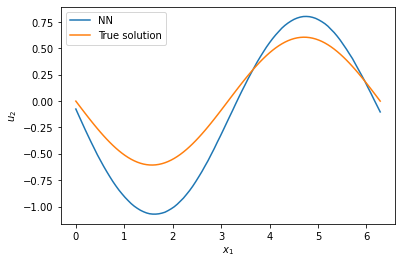

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

## 3-dimensional ABC flow
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = \left(A \sin(x_3) + C \cos(x_2)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_2(t, x) = \left(B \sin(x_1) + A \cos(x_3)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_3(t, x) = \left(C \sin(x_2) + B \cos(x_1)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_0(t, x) = -\left(AC \sin(x_3) \cos(x_2) + BA \sin(x_1) \cos(x_3) + CB \sin(x_2) \cos(x_1)\right) e^{-\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2,x_3) \in [0,2\pi]^3$.

In [7]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return (A * np.sin(x[2]) + C * np.cos(x[1])) * np.exp(-nu / 2 * (T - t))
    elif coordinate == 1:
        return (B * np.sin(x[0]) + A * np.cos(x[2])) * np.exp(-nu / 2 * (T - t))
    else:
        return (C * np.sin(x[1]) + B * np.cos(x[0])) * np.exp(-nu / 2 * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return (A * torch.sin(tx[3]) + C * torch.cos(tx[2])) * torch.exp(-nu / 2 * (T - tx[0]))
    elif coordinate == 1:
        return (B * torch.sin(tx[1]) + A * torch.cos(tx[3])) * torch.exp(-nu / 2 * (T - tx[0]))
    else:
        return (C * torch.sin(tx[2]) + B * torch.cos(tx[1])) * torch.exp(-nu / 2 * (T - tx[0]))

def exact_example_p_tensor(tx):
    return -torch.exp(-nu * (T - tx[0])) * (
        A * C * torch.sin(tx[3]) * torch.cos(tx[2])
        + B * A * torch.sin(tx[1]) * torch.cos(tx[3])
        + C * B * torch.sin(tx[2]) * torch.cos(tx[1])
    )

problem_name = "abc_3d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .7, nu = .02

In [8]:
T, nu = .7, .02

torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=10000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/notebooks/logs/20221106-214424-abc_3d
Epoch 0 with loss 1.336953043937683
Epoch 500 with loss 0.009339217096567154
Epoch 1000 with loss 0.002137829316779971
Epoch 1500 with loss 0.0007588527514599264
Epoch 2000 with loss 0.00037883035838603973
Epoch 2500 with loss 0.00023038985091261566
Epoch 3000 with loss 0.00016641803085803986
Epoch 3500 with loss 0.00010837490845005959
Epoch 4000 with loss 7.435668521793559e-05
Epoch 4500 with loss 0.00012648555275518447
Epoch 5000 with loss 9.534237324260175e-05
Epoch 5500 with loss 3.7798301491420716e-05
Epoch 6000 with loss 4.644060391001403e-05
Epoch 6500 with loss 2.768871490843594e-05
Epoch 7000 with loss 2.0135890736128204e-05
Epoch 7500 with loss 2.1140593162272125e-05
Epoch 8000 with loss 5.481932021211833e-05
Epoch 8500 with loss 1.5528028598055243e-05
Epoch 9000 with loss 2.4262702936539426e-05
Epoch 9500 with loss 1.9993891328340396e-05
Epoch 9999 with loss 1.25807655422249

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.78E+00 & 2.79E+00 & 2.81E+00 & 2.82E+00 & 2.83E+00 & 2.84E+00 & 2.85E+00 & 2.86E+00 & 2.87E+00 & 2.88E+00 & --- \\
$\hat{e}_1(t_k)$
& 2.99E+00 & 2.99E+00 & 2.99E+00 & 2.99E+00 & 2.99E+00 & 2.98E+00 & 2.98E+00 & 2.97E+00 & 2.97E+00 & 2.96E+00 & --- \\
$\hat{e}_2(t_k)$
& 1.54E-01 & 1.25E-01 & 9.91E-02 & 7.60E-02 & 5.59E-02 & 3.89E-02 & 2.49E-02 & 1.40E-02 & 6.27E-03 & 1.67E-03 & --- \\
$\hat{e}(t_k)$
& 3.66E+00 & 3.66E+00 & 3.65E+00 & 3.65E+00 & 3.65E+00 & 3.64E+00 & 3.64E+00 & 3.63E+00 & 3.63E+00 & 3.63E+00 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.24E+00 & 1.23E+00 & 1.23E+00 & 1.22E+00 & 1.21E+00 & 1.21E+00 & 1.21E+00 & 1.20E+00 & 1.20E+00 & 1.19E+00 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 8.44E-01 & 8.38E-01 & 8.33E-01 & 8.28E-01 & 8.24E-01 & 8.20E-01 & 8.18E-01 & 8.15E-01 & 8.14E-01 & 8.13E-01 & --- \\

The 

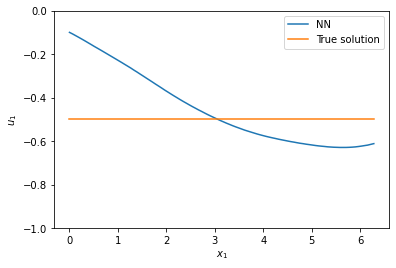

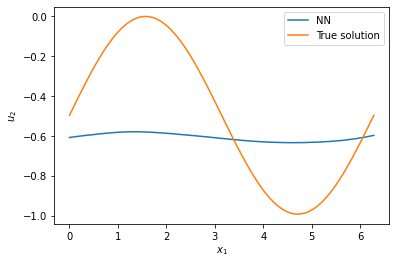

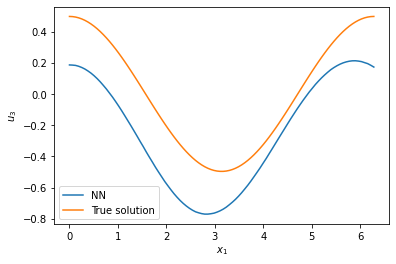

In [9]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 0))